# Phugoid Dynamics

## This notebook:
1) Defines the EOMs for a phugoid system
2) Builds an RK4 solver to numerically integrate the system
3) Analyzes the solver to ensure proper error convergence
4) Models phugoid motion at varying flight altitudes and for varying aircraft sizes

### Import the necessary Python libraries

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

### Phugoid Model: Right-Hand Side Function

This function defines the right-hand side of the phugoid equations governing the motion of a glider under the influence of gravity, aerodynamic forces, and thrust. Given the state vector $ \mathbf{x} = [V, \theta, h, x] $, where:
- $ V $ is the velocity,
- $ \theta $ is the flight path angle,
- $ h $ is the altitude,
- $ x $ is the horizontal position,

the system dynamics are described by:

$$
\begin{aligned}
    \frac{dV}{dt} &= -g \sin(\theta) - \frac{D}{m} + \frac{T}{m}, \\
    \frac{d\theta}{dt} &= \frac{-g \cos(\theta) + L / m}{V}, \\
    \frac{dh}{dt} &= V \sin(\theta), \\
    \frac{dx}{dt} &= V \cos(\theta).
\end{aligned}
$$

where:
- $ g $ is gravitational acceleration,
- $ D = \frac{1}{2} \rho C_D S V^2 $ is the drag force,
- $ L = \frac{1}{2} \rho C_L S V^2 $ is the lift force,
- $ T $ is the thrust force,
- $ \rho $ is the air density,
- $ C_D $ and $ C_L $ are the drag and lift coefficients, respectively,
- $ S $ is the wing area, and
- $ m $ is the glider mass.

The function returns the state vector, which can be used for numerical integration of the system.


In [16]:
def phugoid_rhs(t, state, params):
    g, rho = params['g'], params['rho']
    C_D, C_L, wing_area = params['C_D'], params['C_L'], params['wing_area']
    m = params['m']
    T = params['T']

    V, theta, h, x = state  # Extract variables
    D = 0.5 * rho * C_D * wing_area * V**2  # Drag force
    L = 0.5 * rho * C_L * wing_area * V**2
    dVdt = -g * np.sin(theta) - D / m + T / m
    dthetadt = ((-g * np.cos(theta)) + L / m) / V
    dhdt = V * np.sin(theta)  # Altitude rate of change
    dxdt = V * np.cos(theta)

    return np.array([dVdt, dthetadt, dhdt, dxdt])

### Fourth-Order Runge-Kutta Method (RK4)

The function `runge_kutta4` implements the classical fourth-order Runge-Kutta (RK4) method for numerically solving an initial value problem of the form:

$$
\frac{dy}{dt} = f(t, y)
$$

#### Inputs:
- `f`: The function defining the system's right-hand side, $ f(t, y, \text{params}) $.
- `y0`: The initial state vector $ y(0) $.
- `t_values`: An array of time points where the solution is computed.
- `params`: A dictionary of parameters passed to $ f $.

#### Algorithm:
Given a time step $ \Delta t = t_{i+1} - t_i $, the next state $ y_{i+1} $ is computed as:

$$
\begin{aligned}
    k_1 &= \Delta t \cdot f(t_i, y_i, \text{params}) \\
    k_2 &= \Delta t \cdot f\left(t_i + \frac{\Delta t}{2}, y_i + \frac{k_1}{2}, \text{params}\right) \\
    k_3 &= \Delta t \cdot f\left(t_i + \frac{\Delta t}{2}, y_i + \frac{k_2}{2}, \text{params}\right) \\
    k_4 &= \Delta t \cdot f\left(t_i + \Delta t, y_i + k_3, \text{params}\right) \\
    y_{i+1} &= y_i + \frac{1}{6} (k_1 + 2k_2 + 2k_3 + k_4)
\end{aligned}
$$

This method provides a fourth-order accurate numerical solution to ordinary differential equations. The function returns an array of state values over time.


In [17]:
def runge_kutta4(f, y0, t_values, params):

    y_values = np.zeros((len(t_values), len(y0)))
    y_values[0] = y0
    dt = t_values[1] - t_values[0]

    for i in range(1, len(t_values)):
        t = t_values[i-1]
        y = y_values[i-1]
        k1 = dt * f(t, y, params)
        k2 = dt * f(t + dt/2, y + k1/2, params)
        k3 = dt * f(t + dt/2, y + k2/2, params)
        k4 = dt * f(t + dt, y + k3, params)
        y_values[i] = y + (k1 + 2*k2 + 2*k3 + k4) / 6

    return y_values

### Gulfstream G280 Aircraft Parameters and Initial Conditions

The following dictionary defines the physical and aerodynamic properties of a Gulfstream G280 business jet:

$$
\text{G280} = \{
\begin{aligned}
    g &= 9.81 \quad &\text{(Gravity, m/s}^2\text{)} \\
    \rho &= 1.225 \quad &\text{(Air density, kg/m}^3\text{)} \\
    C_D &= 0.03 \quad &\text{(Drag coefficient)} \\
    C_L &= 1.0 \quad &\text{(Lift coefficient)} \\
    S &= 34.6 \quad &\text{(Wing area, m}^2\text{)} \\
    m &= 17200 \quad &\text{(Aircraft mass, kg)} \\
    T &= 5000 \quad &\text{(Thrust, N)} 
\end{aligned}
\}
$$

#### Initial Conditions:
$$
\begin{aligned}
    V_0 &= 100.0 \quad &\text{(Initial velocity, m/s)} \\
    \theta_0 &= 0.05 \quad &\text{(Initial pitch angle, rad)} \\
    h_0 &= 5000 \quad &\text{(Initial altitude, m)} \\
    x_0 &= 0.0 \quad &\text{(Initial horizontal position, m)}
\end{aligned}
$$

The initial state vector is defined as:

$$
y_0 = \begin{bmatrix} V_0 & \theta_0 & h_0 & x_0 \end{bmatrix}
$$

These parameters and initial conditions are used for simulating the aircraft's flight dynamics.


In [18]:
# Specs for a Gulfstream G280
G280 = {
    'g': 9.81,         # Gravity (m/s^2)
    'rho': 1.225,      # Air density (kg/m^3)
    'C_D': 0.03,       # Drag coefficient
    'C_L': 1.0,        # Lift coefficient
    'wing_area': 34.6, # Wing area (m^2)
    'm': 17200,        # Mass (kg)
    'T': 5000          # Thrust (N)
}

# Initial conditions
v0 = 100.0   # Initial velocity (m/s)
theta0 = 0.05  # Initial pitch angle (rad)
h0 = 5000   # Initial altitude (m)
x0 = 0.0
y0 = np.array([v0, theta0, h0, x0])

### Pseudo-analytical Solution and Error Analysis

To evaluate the accuracy of our numerical approximation using the fourth-order Runge-Kutta method, we compare it against a high-precision reference solution computed using `solve_ivp` with the `DOP853` method. The reference solution serves as a pseudo-analytical benchmark.

#### Numerical Integration Setup
- **Final time:** $ t_{\text{final}} = 600 $ s
- **Number of time steps:** $ N = \{500, 1000, 1500, 2000\} $
- **Reference solver:** `solve_ivp` with `DOP853` (high accuracy: `rtol=10^{-10}`, `atol=10^{-12}`)
- **Error metric:** Relative normed error between Runge-Kutta and reference solution

#### Error Computation
For each time step $ N $, we compute the numerical solution using `runge_kutta4` and compare it with the pseudoanalytical solution. The relative error for each state variable is computed as:

$$
\text{Error} = \frac{\| y_{\text{numeric}} - y_{\text{analytical}} \|}{\| y_{\text{analytical}} \|}
$$

where $ y_{\text{numeric}} $ and $ y_{\text{analytical}} $ are the numerical and reference solutions, respectively.

#### Step Size and Convergence Analysis
- The step size is computed as:

$$
h = \frac{t_{\text{final}}}{N}
$$

- The theoretical fourth-order convergence rate is verified by comparing the numerical errors with a reference $ O(h^4) $ trend:

$$
\text{Reference Error} = c \cdot h^4
$$

where $ c $ is a proportionality constant determined from the smallest step size.

#### Error Visualization
The errors for velocity, pitch angle, altitude, and horizontal displacement are plotted on a log-log scale against step size $ h $. These plots confirm the expected fourth-order accuracy of the Runge-Kutta method.



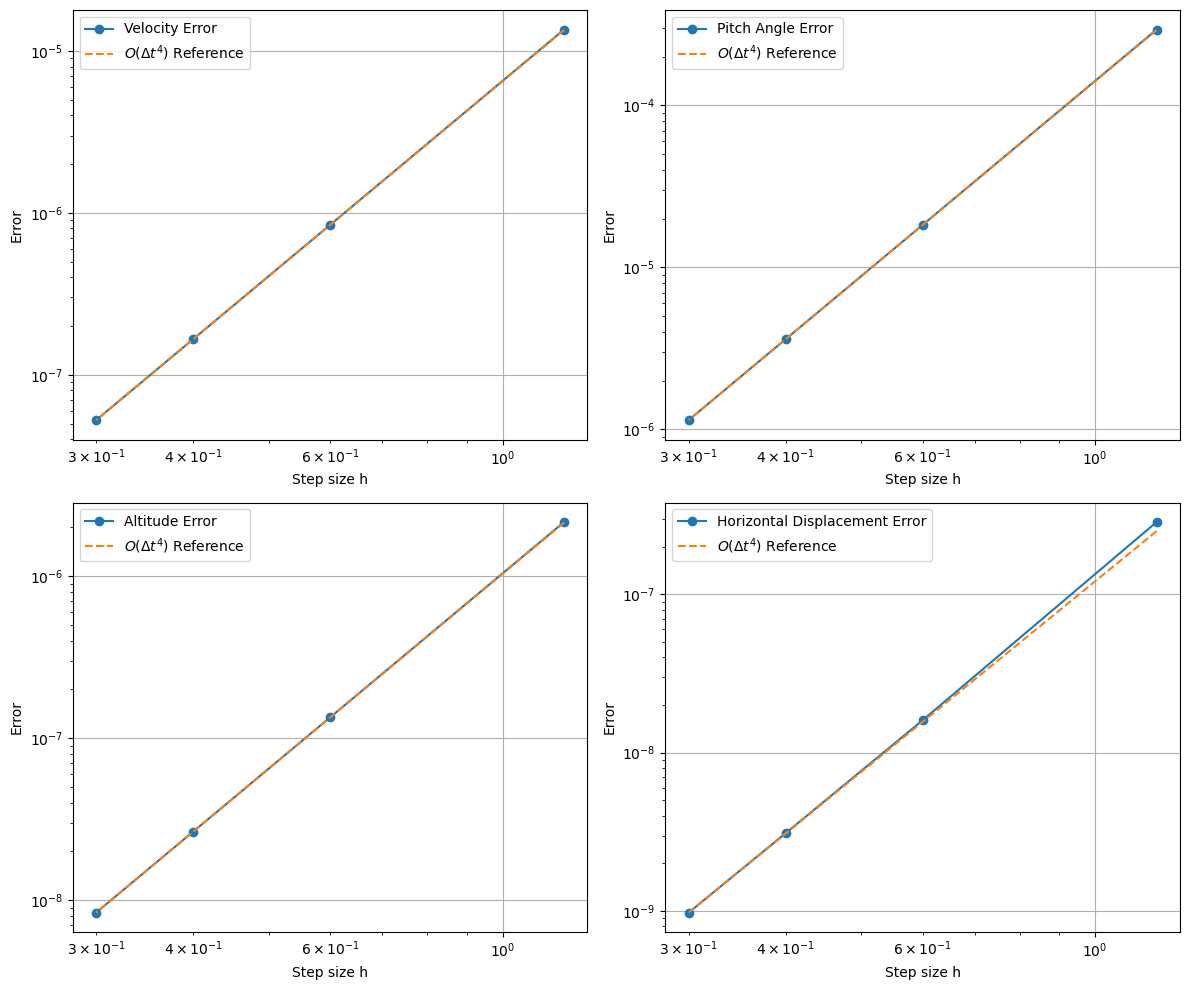

In [19]:
# Use scipy's solve_ivp function to compute a psuedoanalytical solution
# We will use this solution to compare our approximation to in the error analysis below

# Compute the error plots for each solution in the first order system

t_final = 600  # Final time in seconds
N_values = [500, 1000, 1500, 2000]  # Number of time steps

errors_v = []
errors_theta = []
errors_h = []
errors_x = []

for n in N_values:
    t_values = np.linspace(0, t_final, n)
    y_numeric = runge_kutta4(phugoid_rhs, y0, t_values, G280)
    analytical_soln = solve_ivp(phugoid_rhs, [0, t_final], y0, args=(G280,), t_eval=t_values, method='DOP853', rtol=1e-10, atol=1e-12)

    y_analyt = analytical_soln['y'].T
    V_analyt = y_analyt[:, 0]
    theta_analyt = y_analyt[:, 1]
    h_analyt = y_analyt[:, 2] # Convert to [km]
    x_analyt = y_analyt[:, 3] # Convert to [km]

    # Extract solutions
    V_num = y_numeric[:, 0]
    theta_num = y_numeric[:, 1]
    h_num = y_numeric[:, 2]
    x_num = y_numeric[:, 3]

    # Compute error norms
    errors_v.append(np.linalg.norm(V_num - V_analyt) / np.linalg.norm(V_analyt))
    errors_theta.append(np.linalg.norm(theta_num - theta_analyt) / np.linalg.norm(theta_analyt))
    errors_h.append(np.linalg.norm(h_num - h_analyt) / np.linalg.norm(h_analyt))
    errors_x.append(np.linalg.norm(x_num - x_analyt) / np.linalg.norm(x_analyt))

# Compute step sizes
h_values = np.array([t_final / n for n in N_values])
c_v = errors_v[-1] / (h_values[-1]**4)
c_theta = errors_theta[-1] / (h_values[-1]**4)
c_h = errors_h[-1] / (h_values[-1]**4)
c_x = errors_x[-1] / (h_values[-1]**4)

# Reference O(h^4) line
h_ref = np.array(h_values)
error_ref_v = c_v * h_values**4
error_ref_theta = c_theta * h_values**4
error_ref_h = c_h * h_values**4
error_ref_x = c_x * h_values**4

# Plot errors
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs[0, 0].loglog(h_values, errors_v, 'o-', label='Velocity Error')
axs[0, 0].loglog(h_values, error_ref_v, '--', label=r'$O(\Delta t^4)$ Reference')
axs[0, 0].set_xlabel('Step size h')
axs[0, 0].set_ylabel('Error')
axs[0, 0].legend()
axs[0, 0].grid()

axs[0, 1].loglog(h_values, errors_theta, 'o-', label='Pitch Angle Error')
axs[0, 1].loglog(h_values, error_ref_theta, '--', label=r'$O(\Delta t^4)$ Reference')
axs[0, 1].set_xlabel('Step size h')
axs[0, 1].set_ylabel('Error')
axs[0, 1].legend()
axs[0, 1].grid()

axs[1, 0].loglog(h_values, errors_h, 'o-', label='Altitude Error')
axs[1, 0].loglog(h_values, error_ref_h, '--', label=r'$O(\Delta t^4)$ Reference')
axs[1, 0].set_xlabel('Step size h')
axs[1, 0].set_ylabel('Error')
axs[1, 0].legend()
axs[1, 0].grid()

axs[1, 1].loglog(h_values, errors_x, 'o-', label='Horizontal Displacement Error')
axs[1, 1].loglog(h_values, error_ref_x, '--', label=r'$O(\Delta t^4)$ Reference')
axs[1, 1].set_xlabel('Step size h')
axs[1, 1].set_ylabel('Error')
axs[1, 1].legend()
axs[1, 1].grid()

plt.tight_layout()
plt.show()

# General Phugoid Behavior

The phugoid motion describes the longitudinal oscillatory behavior of an aircraft in gliding flight. This simulation solves the phugoid equations of motion using the **fourth-order Runge-Kutta method**.

## Numerical Integration
The system is integrated over **600 seconds** using **2000 time steps**, solving for $V(t)$, $\theta(t)$, $h(t)$, and $x(t)$. The results are visualized as follows:

1. **Velocity vs. Time**: Shows oscillatory behavior in airspeed.
2. **Pitch Angle vs. Time**: Depicts the variation in aircraft attitude.
3. **Altitude vs. Horizontal Distance**: Illustrates the trajectory.
4. **Altitude and Velocity vs. Time**: Compares altitude and velocity on dual axes.

Additional analyses can include:
- **Phase Portraits**: $(V, h)$ and $(\theta, V)$ plots to visualize energy exchange.
- **Flight Path Angle**: plotting $h$ and $x$ to study trajectory changes.

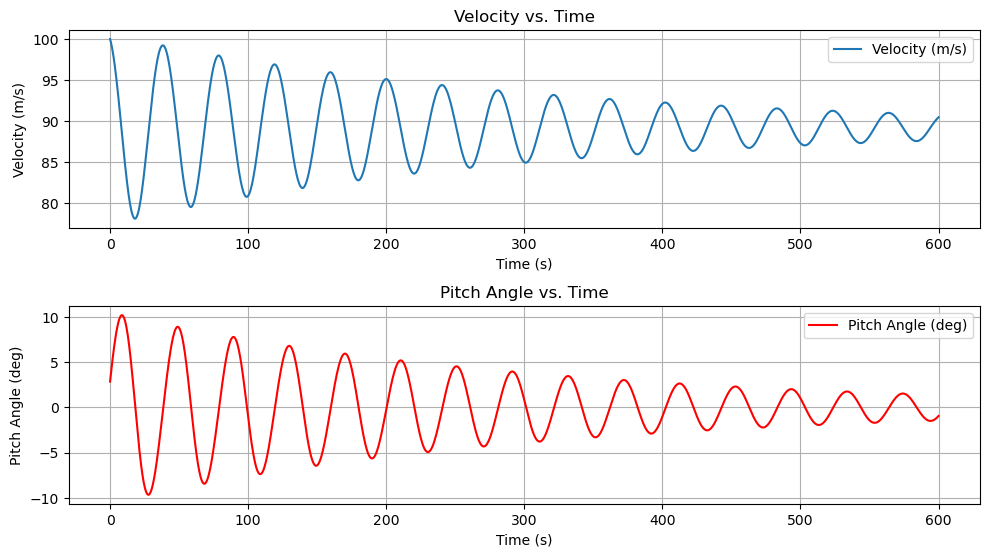

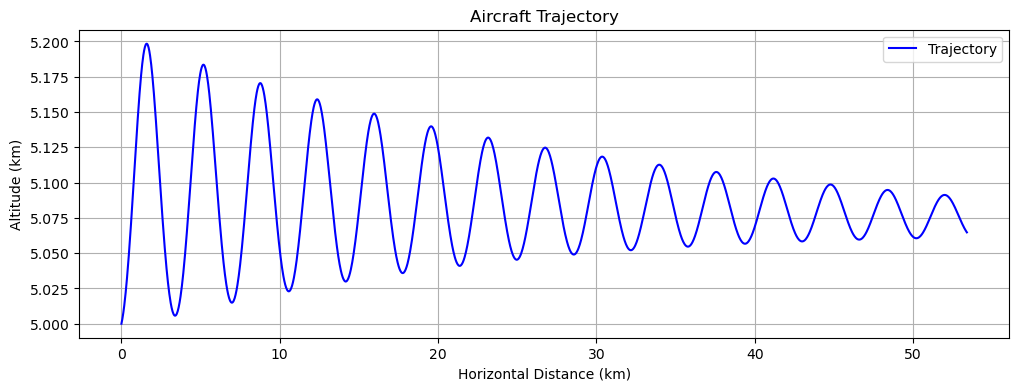

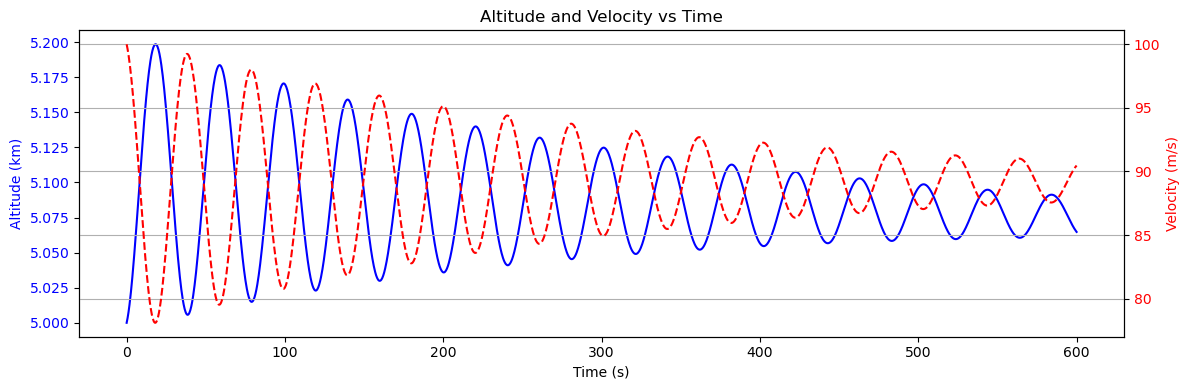

In [20]:
# General phugoid behavior

t_final = 600 # Simulation time (s)
N_val = 2000 # Number of time steps
t_values = np.linspace(0, t_final, N_val)

soln = runge_kutta4(phugoid_rhs, y0, t_values, G280)

V_soln = soln[:, 0]
theta_soln = soln[:, 1]
h_soln = soln[:, 2] / 1000 # Convert to [km]
x_soln = soln[:, 3] / 1000 # Convert to [km]

# Plot results
plt.figure(figsize=(10, 8))
plt.subplot(3, 1, 1)
plt.plot(t_values, V_soln, label='Velocity (m/s)')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity vs. Time')
plt.grid()
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(t_values, np.degrees(theta_soln), label='Pitch Angle (deg)', color='r')
plt.xlabel('Time (s)')
plt.ylabel('Pitch Angle (deg)')
plt.title('Pitch Angle vs. Time')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(x_soln, h_soln, label='Trajectory', color='b')
plt.xlabel('Horizontal Distance (km)')
plt.ylabel('Altitude (km)')
plt.title('Aircraft Trajectory')
plt.legend()
plt.grid()
plt.show()

fig, ax1 = plt.subplots(figsize=(12, 4))

# Altitude on left y-axis
ax1.plot(t_values, h_soln, 'b-', label='Altitude')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Altitude (km)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create second y-axis for velocity
ax2 = ax1.twinx()
ax2.plot(t_values, V_soln, 'r--', label='Velocity')
ax2.set_ylabel('Velocity (m/s)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Optional: Add title and grid
plt.title('Altitude and Velocity vs Time')
fig.tight_layout()
plt.grid()
plt.show()


# RK4 Stability Region

The **stability region** of a numerical method determines the set of values for the scaled eigenvalues $\lambda h$ of a differential equation where the method remains stable. For the **fourth-order Runge-Kutta (RK4) method**, the **stability function** is given by:

$$
R(z) = 1 + z + \frac{z^2}{2} + \frac{z^3}{6} + \frac{z^4}{24}
$$

where $ z = \lambda h $ is the complex-scaled eigenvalue.

## Computational Approach
1. **Mesh Grid Generation**:  
   - A complex grid of values $z = x + i y$ is created over the range $[-3,3]$ in both real and imaginary components.
2. **Evaluation of Stability Function**:  
   - The magnitude of the RK4 stability function, $ |R(z)| $, is computed over this grid.
3. **Contour Plot of Stability Region**:  
   - The region where $ |R(z)| \leq 1 $ (indicating stability) is shaded in red.
   - The contour at $ |R(z)| = 1 $ is drawn as a dashed red line.

## Interpretation
- The **stability region** is a key factor in choosing step sizes for explicit RK4 integration.
- The method is **conditionally stable**, meaning it can only integrate certain eigenvalues without growing errors.

This visualization helps demonstrate the robust stability of RK4.


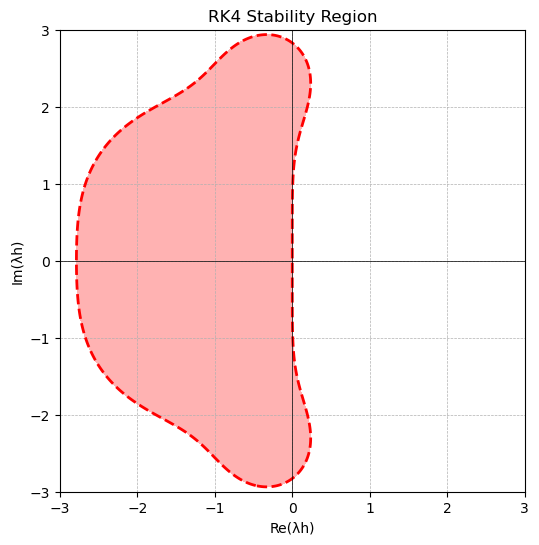

In [21]:
# Generate data for RK4 stability plot using a grid
x_vals = np.linspace(-3, 3, 300)
y_vals = np.linspace(-3, 3, 300)
X, Y = np.meshgrid(x_vals, y_vals)
Z = X + 1j * Y  # Complex grid

# Compute RK4 stability function R(z)
RZ = 1 + Z + (Z**2) / 2 + (Z**3) / 6 + (Z**4) / 24
stability_region = np.abs(RZ)

# Plot RK4 stability region
plt.figure(figsize=(6, 6))
plt.contourf(X, Y, stability_region, levels=[0, 1], colors=['red'], alpha=0.3)
plt.contour(X, Y, stability_region, levels=[1], colors=['r'], linewidths=2, linestyles="dashed")

plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.xlabel("Re(λh)")
plt.ylabel("Im(λh)")
plt.title("RK4 Stability Region")
plt.grid(True, linestyle="--", linewidth=0.5)

# Show the plot
plt.show()

# Effect of Air Density on Phugoid Motion

## Overview
This analysis examines how varying **air density** affects the phugoid motion of a Gulfstream G280 aircraft. The phugoid motion is simulated for three different air densities corresponding to **sea level, 15,000 ft (5 km), and 32,000 ft (10 km)** while keeping all other parameters constant.

## Simulation Parameters
The key parameters for the simulations are:

| Condition      | Air Density (kg/m³) | Altitude Approx. |
|--------------|--------------------|----------------|
| **High Density (Sea Level)** | 1.225 | ~0 km |
| **Mid Density (~15,000 ft)** | 0.7361 | ~5 km |
| **Low Density (~32,000 ft)** | 0.4127 | ~10 km |

Other aircraft properties remain unchanged:
- **Mass**: $ m = 17,200 $ kg  
- **Wing Area**: $ S = 34.6 $ m²  
- **Thrust**: $ T = 5000 $ N  
- **Lift and Drag Coefficients**: $ C_L = 1.0 $, $ C_D = 0.03 $  
- **Gravity**: $ g = 9.81 $ m/s²  

The **initial conditions** for all cases:
- Initial velocity: $ v_0 = 100 $ m/s  
- Initial pitch angle: $ \theta_0 = 0.05 $ rad (~2.86°)  
- Initial altitude: $ h_0 = 5000 $ m  
- Initial horizontal position: $ x_0 = 0 $

## Numerical Method
The **Runge-Kutta 4 (RK4) method** is used to integrate the phugoid equations of motion over a time period of **600 seconds** with **2000 time steps**.

## Results

### 1. Velocity vs. Time
- At higher altitudes (lower density), **velocity increases** due to reduced air resistance.
- At lower altitudes (higher density), **velocity decreases** more rapidly due to greater aerodynamic drag.

### 2. Pitch Angle vs. Time
- The oscillatory **phugoid motion** is evident across all densities.
- The **amplitude of oscillations increases at higher altitudes**, suggesting that reduced aerodynamic damping leads to more pronounced pitch variations.

### 3. Aircraft Trajectory
- The horizontal distance traveled increases with decreasing density (higher altitude).
- The aircraft at **higher altitudes maintains a longer trajectory** due to lower drag.

## Conclusion
- **Higher air density (sea level)** results in **greater aerodynamic damping**, reducing phugoid oscillations and overall velocity.
- **Lower air density (higher altitude)** leads to **longer oscillations, higher velocity, and extended trajectory**, as there is less drag acting on the aircraft.
- The **phugoid oscillation period is longer at high altitude**, aligning with reduced aerodynamic damping.

This study highlights the importance of air density in flight dynamics and stability, particularly for **high-altitude cruise and descent planning**.


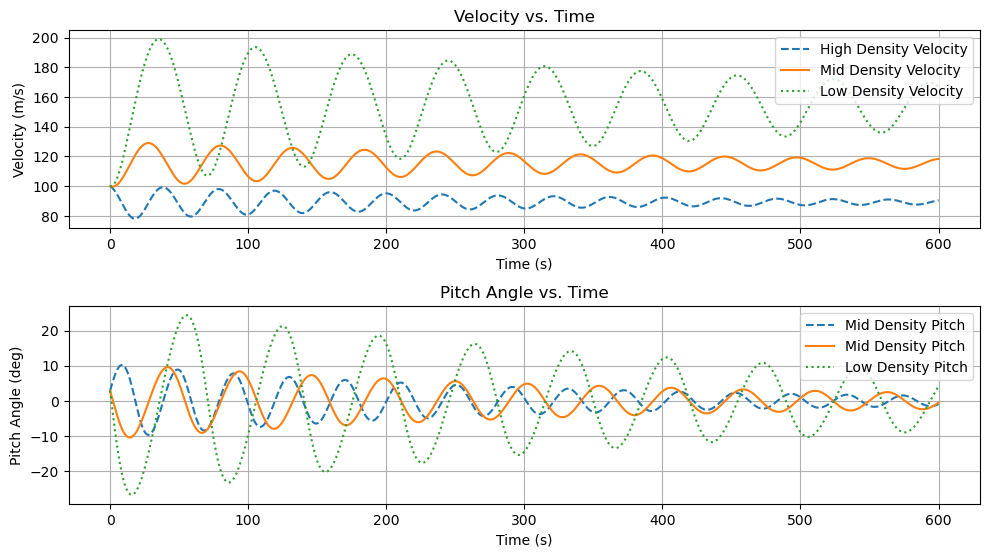

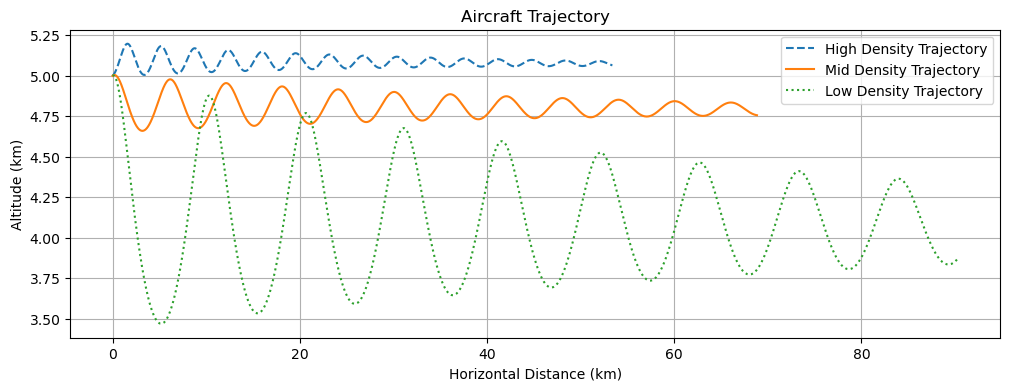

In [22]:
# Answering question 1: What effect does varying the air density have on the phugoid system
# We will analize the Gulfstream G280 with varrying no parameters except for the air density

# Density conditions for close to sea level flight
G280_low = {
    'g': 9.81,         # Gravity (m/s^2)
    'rho': 1.225,      # Air density (kg/m^3)
    'C_D': 0.03,       # Drag coefficient
    'C_L': 1.0,        # Lift coefficient
    'wing_area': 34.6, # Wing area (m^2)
    'm': 17200,        # Mass (kg)
    'T': 5000          # Thrust (N)
}

# Density conditions for roughly 15,000 ft ~ 5 km
G280_mid = {
    'g': 9.81,         # Gravity (m/s^2)
    'rho': 0.7361,      # Air density (kg/m^3)
    'C_D': 0.03,       # Drag coefficient
    'C_L': 1.0,        # Lift coefficient
    'wing_area': 34.6, # Wing area (m^2)
    'm': 17200,        # Mass (kg)
    'T': 5000          # Thrust (N)
}

# Density conditions for roughly 32,000 ft ~ 10 km
G280_high = {
    'g': 9.81,         # Gravity (m/s^2)
    'rho': 0.4127,      # Air density (kg/m^3)
    'C_D': 0.03,       # Drag coefficient
    'C_L': 1.0,        # Lift coefficient
    'wing_area': 34.6, # Wing area (m^2)
    'm': 17200,        # Mass (kg)
    'T': 5000          # Thrust (N)
}

# Initial conditions will remain the same for each simulation
# The altitude will also remain constant for better visualization of each trajectory

v0 = 100.0   # Initial velocity (m/s)
theta0 = 0.05  # Initial pitch angle (rad)
h0 = 5000   # Initial altitude (m)
x0 = 0.0
y0 = np.array([v0, theta0, h0, x0])

t_final = 600
N_val = 2000 # Number of time steps
t_values = np.linspace(0, t_final, N_val)

soln_low = runge_kutta4(phugoid_rhs, y0, t_values, G280_low)
soln_mid = runge_kutta4(phugoid_rhs, y0, t_values, G280_mid)
soln_high = runge_kutta4(phugoid_rhs, y0, t_values, G280_high)

V_low = soln_low[:, 0]
theta_low = soln_low[:, 1]
h_low = soln_low[:, 2] / 1000
x_low = soln_low[:, 3] / 1000

V_mid = soln_mid[:, 0]
theta_mid = soln_mid[:, 1]
h_mid = soln_mid[:, 2] / 1000
x_mid = soln_mid[:, 3] / 1000

V_high = soln_high[:, 0]
theta_high = soln_high[:, 1]
h_high = soln_high[:, 2] / 1000
x_high = soln_high[:, 3] / 1000

plt.figure(figsize=(10, 8))

# Velocity plot
plt.subplot(3, 1, 1)
plt.plot(t_values, V_low, label='High Density Velocity', linestyle='dashed')
plt.plot(t_values, V_mid, label='Mid Density Velocity', linestyle='solid')
plt.plot(t_values, V_high, label='Low Density Velocity', linestyle='dotted')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity vs. Time')
plt.grid()
plt.legend()

# Pitch angle plot
plt.subplot(3, 1, 2)
plt.plot(t_values, np.degrees(theta_low), label='Mid Density Pitch', linestyle='dashed')
plt.plot(t_values, np.degrees(theta_mid), label='Mid Density Pitch', linestyle='solid')
plt.plot(t_values, np.degrees(theta_high), label='Low Density Pitch', linestyle='dotted')
plt.xlabel('Time (s)')
plt.ylabel('Pitch Angle (deg)')
plt.title('Pitch Angle vs. Time')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

# Trajectory plot
plt.figure(figsize=(12, 4))
plt.plot(x_low, h_low, label='High Density Trajectory', linestyle='dashed')
plt.plot(x_mid, h_mid, label='Mid Density Trajectory', linestyle='solid')
plt.plot(x_high, h_high, label='Low Density Trajectory', linestyle='dotted')
plt.xlabel('Horizontal Distance (km)')
plt.ylabel('Altitude (km)')
plt.title('Aircraft Trajectory')
plt.legend()
plt.grid()
plt.show()

# Comparison of Phugoid Motion for Different Aircraft Sizes

## Overview
This analysis compares the **phugoid motion** of three aircraft with different sizes and masses:
1. **Small Aircraft** (Gulfstream G280)
2. **Medium Aircraft** (Embraer E2)
3. **Large Aircraft** (Boeing 787)

All simulations are performed at a fixed altitude of **10,000 m (~32,000 ft)**, where the air density is **0.4127 kg/m³**. The study explores differences in velocity, pitch angle, and trajectory due to variations in mass, wing area, and aerodynamic coefficients.

## Aircraft Parameters

| Aircraft | Mass (kg) | Wing Area (m²) | Drag Coeff. \( C_D \) | Lift Coeff. \( C_L \) | Thrust (N) |
|----------|----------|--------------|-----------------|-----------------|------------|
| **Gulfstream G280** | 17,200 | 46 | 0.022 | 1.0 | 0 |
| **Embraer E2** | 55,000 | 103 | 0.03 | 1.0 | 0 |
| **Boeing 787** | 220,000 | 325 | 0.024 | 1.0 | 0 |

All aircraft start with the following **initial conditions**:
- Initial velocity:  
  - G280: **100 m/s**  
  - Embraer E2: **230 m/s**  
  - Boeing 787: **257 m/s**  
- Initial pitch angle:  
  - G280: **0.05 rad (~2.86°)**  
  - E2 & 787: **0.02 rad (~1.15°)**  
- Initial altitude: **10,000 m**  
- Initial horizontal position: **0 km**

## Numerical Method
- The phugoid equations are solved using the **Runge-Kutta 4 (RK4) method**.
- The time span is **600 seconds** with **2000 time steps**.

## Results

### 1. **Velocity vs. Time**
- The **Boeing 787 (largest mass)** maintains the **highest velocity** due to its high inertia.
- The **G280 (smallest mass)** experiences the most rapid **velocity variations**, showing more pronounced oscillations.
- The **Embraer E2** falls in between, displaying moderate oscillations.

### 2. **Pitch Angle vs. Time**
- The **Boeing 787 has the smoothest pitch oscillations**, with lower amplitude.
- The **G280 has the most pronounced oscillations**, as its lower mass and wing area result in more dynamic response to perturbations.
- The **E2 exhibits intermediate behavior**, with moderate damping.

### 3. **Aircraft Trajectory**
- The **Boeing 787 travels the farthest horizontally**, due to higher inertia and aerodynamic efficiency.
- The **G280 covers the shortest distance**, with steeper altitude oscillations.
- The **Embraer E2 follows a middle trajectory**, demonstrating characteristics between the two extremes.

## Conclusion
- **Mass and wing area significantly affect phugoid motion dynamics**.
- Larger aircraft, with **higher inertia, experience longer oscillation periods** and less aggressive pitch variations.
- Smaller aircraft are **more sensitive to perturbations**, leading to quicker oscillations and reduced flight distance.

This study provides valuable insights into **aircraft stability and energy conservation** during unpowered flight, as well as implies the design points for efficient stability and control systems for different aircraft sizes


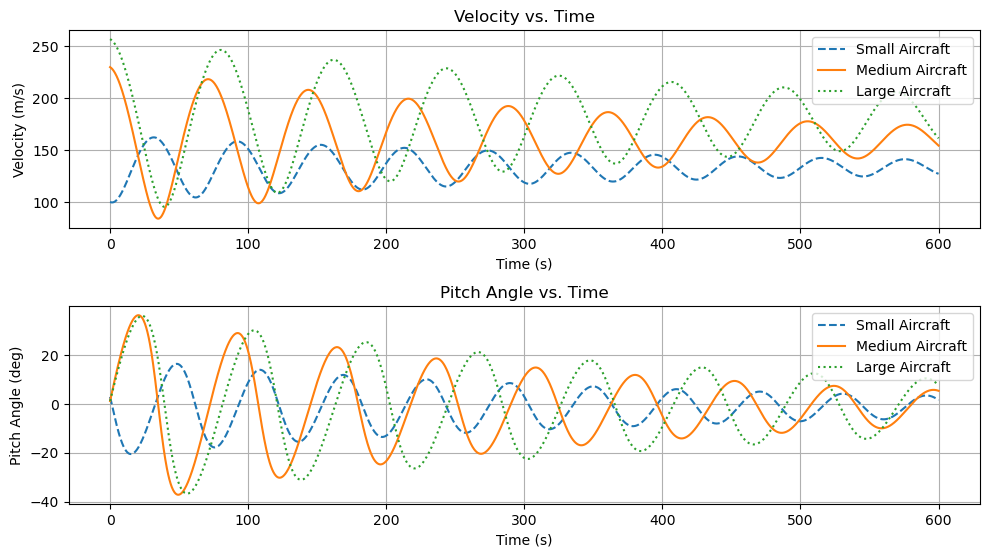

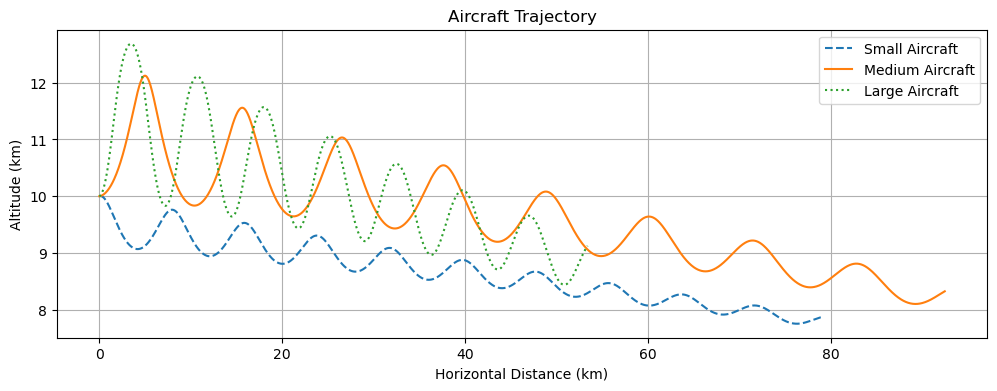

In [23]:
# Parameters for a small aircraft
G280 = {
    'g': 9.81,         # Gravity (m/s^2)
    'rho': 0.4127,      # Air density (kg/m^3)
    'C_D': 0.022,       # Drag coefficient
    'C_L': 1.0,        # Lift coefficient
    'wing_area': 46, # Wing area (m^2)
    'm': 17200,        # Mass (kg)
    'T': 0          # Thrust (N)
}

# Initial conditions for a G280
y0_g280 = np.array([100.00, 0.05, 10000, 0.0])

# Parameters for a mid size aircraft
embraerE2 = {
    'g': 9.81,         # Gravity (m/s^2)
    'rho': 0.4127,     # Air density at ~32,000 ft (kg/m^3)
    'C_D': 0.03,       # Estimated drag coefficient
    'C_L': 1.0,        # Estimated lift coefficient
    'wing_area': 103, # Wing area (m^2)
    'm': 55000,        # Estimated in-flight mass (kg)
    'T': 0         # Estimated thrust (N)
}

y0_E2 = np.array([230.0, 0.02, 10000, 0.0])

# Parameters for a large aircraft
boeing787 = {
    'g': 9.81,         # Gravity (m/s^2)
    'rho': 0.4127,     # Air density at ~32,000 ft (kg/m^3)
    'C_D': 0.024,       # Estimated drag coefficient
    'C_L': 1.0,        # Estimated lift coefficient
    'wing_area': 325,  # Wing area (m^2)
    'm': 220000,       # Estimated in-flight mass (kg)
    'T': 0         # Estimated thrust (N)
}

y0_787 = np.array([257.0, 0.02, 10000, 0.0])

t_final = 600
N_val = 2000 # Number of time steps
t_values = np.linspace(0, t_final, N_val)

soln_g280 = runge_kutta4(phugoid_rhs, y0_g280, t_values, G280)
soln_E2 = runge_kutta4(phugoid_rhs, y0_E2, t_values,embraerE2)
soln_787 = runge_kutta4(phugoid_rhs, y0_787, t_values,boeing787)

V_g280 = soln_g280[:, 0]
theta_g280 = soln_g280[:, 1]
h_g280 = soln_g280[:, 2] / 1000
x_g280 = soln_g280[:, 3] / 1000

V_E2 = soln_E2[:, 0]
theta_E2 = soln_E2[:, 1]
h_E2 = soln_E2[:, 2] / 1000
x_E2 = soln_E2[:, 3] / 1000

V_787 = soln_787[:, 0]
theta_787 = soln_787[:, 1]
h_787 = soln_787[:, 2] / 1000
x_787 = soln[:, 3] / 1000

plt.figure(figsize=(10, 8))

# Velocity plot
plt.subplot(3, 1, 1)
plt.plot(t_values, V_g280, label='Small Aircraft', linestyle='dashed')
plt.plot(t_values, V_E2, label='Medium Aircraft', linestyle='solid')
plt.plot(t_values, V_787, label='Large Aircraft', linestyle='dotted')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity vs. Time')
plt.grid()
plt.legend()

# Pitch angle plot
plt.subplot(3, 1, 2)
plt.plot(t_values, np.degrees(theta_g280), label='Small Aircraft', linestyle='dashed')
plt.plot(t_values, np.degrees(theta_E2), label='Medium Aircraft', linestyle='solid')
plt.plot(t_values, np.degrees(theta_787), label='Large Aircraft', linestyle='dotted')
plt.xlabel('Time (s)')
plt.ylabel('Pitch Angle (deg)')
plt.title('Pitch Angle vs. Time')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

# Trajectory plot
plt.figure(figsize=(12, 4))
plt.plot(x_g280, h_g280, label='Small Aircraft', linestyle='dashed')
plt.plot(x_E2, h_E2, label='Medium Aircraft', linestyle='solid')
plt.plot(x_787, h_787, label='Large Aircraft', linestyle='dotted')
plt.xlabel('Horizontal Distance (km)')
plt.ylabel('Altitude (km)')
plt.title('Aircraft Trajectory')
plt.legend()
plt.grid()
plt.show()